In [1]:
# If ELFI is not installed, append its path so that it can be imported
import sys
sys.path.append('../elfi')

In [2]:
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
import logging
logging.basicConfig(level=logging.INFO)  # logging may not show up in Jupyter without this

# Inference with ELFI: the MA(2) model

The 2nd order moving average model, MA(2), is a common model used in univariate time analysis. Assuming zero mean it can be written as

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2},
$$

where $\theta_1, \theta_2 \in \mathbb{R}$ and $(w_k)_{k\in \mathbb{Z}} \sim N(0,1)$ represents an independent and identically distributed sequence of white noise.

### The observed data and the inference problem

In this notebook, our task is to infer the parameters $\theta_1, \theta_2$ given a sequence of 100 observations $y$ that originate from an MA(2) process. Let's define this MA(2) simulator as a Python function:

In [4]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x

Above, `t1`, `t2`, and `n_obs` are the arguments specific to the MA2 process. The latter two are ELFI specific keyword arguments. In ELFI, operations are normally vectorized, meaning that instead of simulating a single MA2 sequence at a time, we simulate a batch of them. Vectorization is a way to make operations efficient in Python. Above we rely on numpy to carry out the vectorized calculations. The simulator is passed a `batch_size` argument by ELFI to indicate how many simulations are needed. This also implies that `t1` and `t2` are going to be vectors of scalars and that the method returns in this case a 2d array with simulations on the rows.

The other keyword argument `random_state` is for generating random quantities in your simulator. It is a `numpy.RandomState` object that has all the same methods as `numpy.random` module has. Using it ensures that you will get consistent and reliable results. 

**Note**: there is a built-in tool (`elfi.tools.vectorize`) in ELFI to vectorize operations that cannot be otherwise vectorized. It is basically a for loop wrapper for convenience.

**Important**: in order to guarantee a consistent state of pseudo-random number generation, the simulator must have `random_state` as a keyword argument for reading in a `numpy.RandomState` object.

(If you *really* don't want to take advantage of these, you can wrap your function into another that accepts these keyword arguments but simply doesn't use them.)

Let's now use this simulator to create the observations with true parameter values $\theta_1=0.6, \theta_2=0.2$ (from now on these are considered unknown):

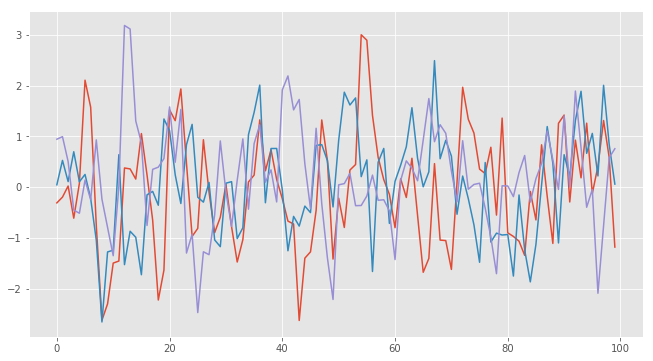

In [5]:
# true parameters
t1_true = 0.6
t2_true = 0.2

# Set up observed data y with some random seed
random_state = np.random.RandomState(20161130)
y_obs = MA2(t1_true, t2_true, random_state=random_state)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t1_true, t2_true).ravel());
plt.plot(MA2(t1_true, t2_true).ravel());

### Approximate Bayesian Computation

Standard statistical inference methods rely on the use of the *likelihood* function. Given a configuration of the parameters, the likelihood function quantifies how likely it is that these values of the parameters produced the observed data. In our simple example case above however, evaluating the likelihood is difficult due to the unobserved latent sequence (variable `w` in the simulator code). In many real world applications the likelihood function is not available or it is too expensive to evaluate preventing the use of traditional inference methods.

One way to approach this problem is to use Approximate Bayesian Computation (ABC) which is a statistically based method replacing the use of the likelihood function with a simulator of the data. Loosely speaking, it is based on the intuition that similar data is likely to have been produced by similar parameters. Looking at the picture above, in essence we would keep simulating until we have found enough sequences that are similar to the observed sequence. Although the idea may appear inapplicable for the task at hand, you will soon see that it does work. For more information about ABC, please see e.g. 

* [Lintusaari, J., Gutmann, M. U., Dutta, R., Kaski, S., and Corander, J. (2016). Fundamentals and recent
developments in approximate Bayesian computation. *Systematic Biology*, doi: 10.1093/sysbio/syw077.](http://sysbio.oxfordjournals.org/content/early/2016/09/07/sysbio.syw077.full.pdf)

* [Marin, J.-M., Pudlo, P., Robert, C. P., and Ryder, R. J. (2012). Approximate Bayesian computational
methods. *Statistics and Computing*, 22(6):1167–1180.](http://link.springer.com/article/10.1007/s11222-011-9288-2)

* https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

### Defining the inference problem in ELFI

In [6]:
import elfi

In ELFI, we build a generative model for the distance between simulations and the observed data. The model will be a directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)), which associates each node with its parent nodes, the last node being the distance. This provides an intuitive means to describe even complex dependencies. Let's build such a model.

As is usual in Bayesian statistical inference, we need to define *prior* distributions for the unknown parameters $\theta_1, \theta_2$. In ELFI the priors can be any of the continuous and discrete distributions available in `scipy.stats` (for custom priors, see [below](#custom_prior)). For simplicity, let's start by assuming that both parameters follow `Uniform(0, 2)`.

In [7]:
# a node is defined by giving a distribution from scipy.stats and its parents (here constants 0 and 2)
t1 = elfi.Prior(scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('uniform', 0, 2)

Next, we define the *Simulator* node by giving it the `MA2` function, and the priors as its parents. As the evaluation of this node can be compared with observations, we give them as well.

In [8]:
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

But how does one compare the simulated sequences with the observed sequence? As could be seen from the plot of just a few observed sequences, a direct pointwise comparison would probably not work very well: the three sequences look quite different although they were generated with the same parameter values. Indeed, the comparison of simulated sequences is often the most difficult (and ad hoc) part of ABC. Typically one chooses one or more summary statistics and then calculates the discrepancy between those.

Here, we will apply the intuition arising from the definition of the MA(2) process, and use the autocovariances with lags 1 and 2 as the summary statistics:

In [9]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

As is familiar by now, a `Summary` node is defined by giving the autocovariance function and the simulated data (which includes the observed as well):

In [10]:
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2

Here, we choose the discrepancy as the common Euclidean L2-distance. ELFI can use many common distances directly from `scipy.spatial.distance` like this:

In [11]:
# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)

One may wish to use a distance function that is unavailable in `scipy.spatial.distance`. ELFI supports defining a custom distance/discrepancy functions as well (see the documentation for `elfi.Distance` and `elfi.Discrepancy`).

Now that the inference model is defined, ELFI can visualize the DAG. __Note__ that you need the [Graphviz](http://www.graphviz.org) software as well as the `graphviz` [Python package](https://pypi.python.org/pypi/graphviz) for drawing this.

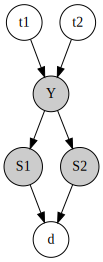

In [12]:
elfi.draw(d)  # just give it a node in the model, or the model itself (d.model)

### Defining custom priors

Although the above definition is perfectly valid, let's use the same priors as in [*Marin et al. (2012)*](http://link.springer.com/article/10.1007/s11222-011-9288-2) that guarantee that the problem will be identifiable (loosely speaking, the likelihood willl have just one mode). Marin et al. used priors for which $-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$ i.e. the parameters are sampled from a triangle (see below).

In ELFI, custom distributions can be defined similar to distributions in `scipy.stats` (i.e. they need to have at least the `rvs` method implemented for the simplest algorithms). To be safe they can inherit `elfi.Distribution` which defines the methods needed. In this case we only need these for sampling, so implementing a static `rvs` method suffices. As was in the context of simulators, it is important to accept the keyword argument `random_state`, which is needed for ELFI's internal book-keeping of pseudo-random number generation. Also the `size` keyword is needed (which in the simple cases is the same as the `batch_size` in the simulator definition).

In [13]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

These indeed sample from a triangle:

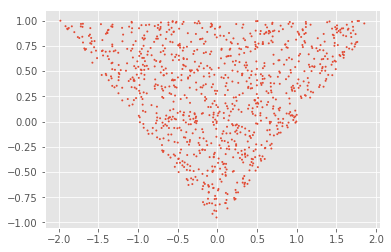

In [14]:
t1_1000 = CustomPrior_t1.rvs(2, 1000)
t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=4, edgecolor='none');
# plt.plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')  # outlines of the triangle

Let's change the earlier priors to the new ones in the inference model:

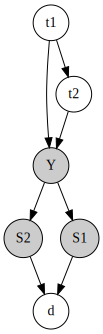

In [15]:
t1.become(elfi.Prior(CustomPrior_t1, 2))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))

elfi.draw(d)

Note that `t2` now depends on `t1`. Yes, ELFI supports hierarchy.

### Basic inference with rejection sampling

The simplest ABC algorithm samples parameters from their prior distributions, runs the simulator with these and compares them to the observations. The samples are either accepted or rejected depending on how large the distance is. The accepted samples represent samples from the approximate posterior distribution.

In ELFI, ABC methods are initialized either with a node giving the distance, or with the `ElfiModel` object and the name of the distance node. Depending on the inference method, additional arguments may be accepted or required. 

A common optional keyword argument, accepted by all inference methods, `batch_size` defines how many simulations are performed in each passing through the graph. In Python, doing many calculations with a single function call can potentially save a lot of CPU time, depending on the operation. For example, here we draw 10000 samples from `t1`, give them as input to `t2` and draw 10000 samples from it, use these to run 10000 simulations etc. all in just one passing through the graph and hence the overall number of function calls is reduced 10000-fold. However, this does not mean that batches should be as big as possible, since you may run out of memory, the fraction of time spent in function call overhead becomes insignificant, and many algorithms operate in multiples of `batch_size`. Furthermore, the `batch_size` is a crucial element for efficient parallelization (see the notebook on parallelization).

In [16]:
rej = elfi.Rejection(d, batch_size=10000)

After the ABC method has been initialized, samples can be drawn from it. By default, rejection sampling in ELFI works in `quantile` mode i.e. a certain quantile of the samples with smallest discrepancies is accepted. The `sample` method requires the number of output samples as a parameter. Note that the simulator is then run `(N/quantile)` times. (Alternatively, the same behavior can be achieved by saying `n_sim=1000000`.)

The IPython magic command `%time` is used here to give you an idea of runtime on a typical personal computer.

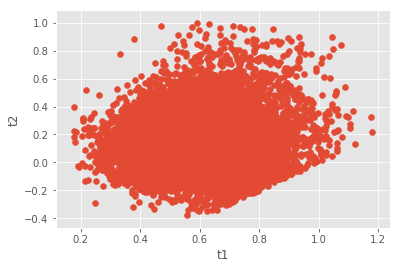

CPU times: user 28.7 s, sys: 1.88 s, total: 30.6 s
Wall time: 31.1 s


In [17]:
N = 10000

# You can give the sample method `vis=True` to see an animation how the prior transforms towards the
# posterior with a decreasing threshold (this will slow it down a bit though).
%time result = rej.sample(N, quantile=0.01, vis=True)

The `sample` method returns a `Result` object, which contains several attributes and methods. Most notably the attribute `samples` contains an OrderedDict (i.e. an ordered Python dictionary) of the posterior numpy arrays for all non-constant elfi.Priors in the model. For rejection sampling, other attributes include e.g. the `threshold`, which is the threshold value resulting in the requested quantile. 

In [18]:
result.samples['t1'].mean()

0.5926

The `Result` object includes a convenient `summary` method:

In [19]:
result.summary

Method: Rejection
Number of posterior samples: 10000
Number of simulations: 1000000
Threshold: 0.113
Posterior means: t1: 0.593, t2: 0.164


Rejection sampling can also be performed threshold-based so that it accepts all samples that result in a discrepancy below certain threshold. Note that since we require a fixed number of samples, there is no guarantee how many times the simulator will be run.

In [20]:
%time result2 = rej.sample(N, threshold=0.2)

print(result2)  # the Result object's __str__ contains the output from summary()

CPU times: user 1.71 s, sys: 379 ms, total: 2.09 s
Wall time: 2.11 s
Method: Rejection
Number of posterior samples: 10000
Number of simulations: 330000
Threshold: 0.199
Posterior means: t1: 0.586, t2: 0.164



### Storing simulated values

As the samples are already in numpy arrays, you can just say e.g. `np.savetxt('t1.txt', result.samples['t1'])` to save them. However, ELFI provides some additional functionality. You may define a *pool* for storing the simulation results (not just the accepted samples) for certain nodes:

In [21]:
pool = elfi.OutputPool(['t1', 't2', 'S1', 'S2'])
rej = elfi.Rejection(d, pool=pool)

%time result3 = rej.sample(N, n_sim=1000000)
result3

CPU times: user 7.06 s, sys: 136 ms, total: 7.2 s
Wall time: 7.38 s


Method: Rejection
Number of posterior samples: 10000
Number of simulations: 1000000
Threshold: 0.114
Posterior means: t1: 0.593, t2: 0.162

The benefit of the pool is that you may reuse simulations without having to resimulate them. Above we saved the summaries to the pool, so we can change the distance node of the model without having to resimulate anything. Let's do that.

In [22]:
# Replace the current distance with a cityblock (manhattan) distance and recreate the inference
d.become(elfi.Distance('cityblock', S1, S2, p=1))
rej = elfi.Rejection(d, pool=pool)

%time result4 = rej.sample(N, n_sim=1000000)
result4

CPU times: user 1.32 s, sys: 21 ms, total: 1.34 s
Wall time: 1.39 s


Method: Rejection
Number of posterior samples: 10000
Number of simulations: 1000000
Threshold: 0.143
Posterior means: t1: 0.593, t2: 0.163

Note the significant saving in time, even though the total number of considered simulations stayed the same. 

We can also increase the total amount of simulations and only have to simulate the new ones:

In [23]:
%time result5 = rej.sample(N, n_sim=1200000)
result5

CPU times: user 2.31 s, sys: 30.9 ms, total: 2.34 s
Wall time: 2.38 s


Method: Rejection
Number of posterior samples: 10000
Number of simulations: 1200000
Threshold: 0.131
Posterior means: t1: 0.593, t2: 0.163

Above the results were saved into a python dictionary (the pool). If you store a lot of large data to there, you will eventually 
run out of memory. Instead you can use arrays persisted to standard .npy files. ELFI makes it possible to append
to these arrays as well.

In [24]:
arraypool = elfi.store.ArrayPool(['t1', 't2', 'Y', 'd'], basepath='./output')
rej = elfi.Rejection(d, pool=arraypool)
%time result5 = rej.sample(100, threshold=0.3)

CPU times: user 29.1 ms, sys: 2.68 ms, total: 31.8 ms
Wall time: 33.4 ms


This stores the simulated data in binary `npy` format under seed-specific directory `arraypool.path`, and can be loaded with `np.load`. (**Note:** depending on your operating system, you may have to run `arraypool.flush()` before you can access the files while this notebook is open.)

In [25]:
arraypool.flush()
!ls $arraypool.path

Y.npy  d.npy  t1.npy t2.npy


Now lets load all the parameters `t1` that were generated with numpy:

In [26]:
np.load(arraypool.path + '/t1.npy')

array([ 0.21366029,  0.44198885, -0.24426312, ...,  1.56711699,
       -0.2995884 ,  0.93440687])

You can delete the files with:

In [27]:
arraypool.delete()

!ls $arraypool.path  # verify the deletion

ls: ./output/arraypool/3476499457: No such file or directory


### Visualizing the results

Instances of `Result` contain methods for some basic plotting (these are convenience methods to plotting functions defined under `elfi.visualization`).

For example one can plot the marginal distributions:

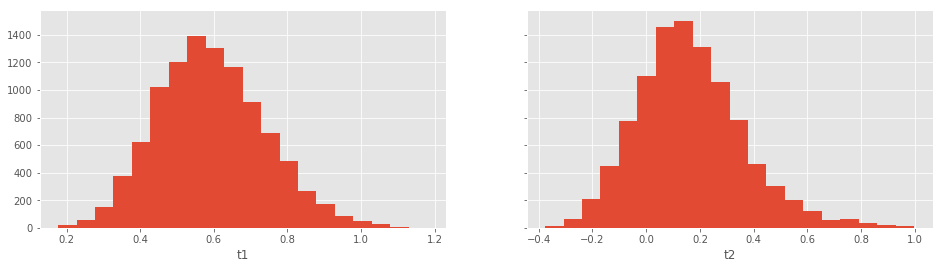

In [28]:
result.plot_marginals();

Often "pairwise relationships" are more informative:

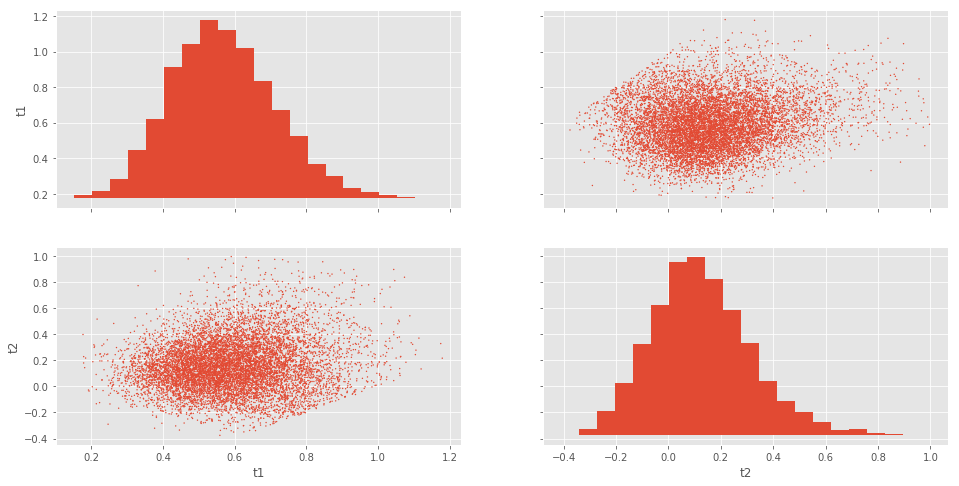

In [29]:
result.plot_pairs();

Note that if working in a non-interactive environment, you can use e.g. `plt.savefig('pairs.png')` after a ELFI plotting command to save the current figure to disk.

### Sequential Monte Carlo ABC

Rejection sampling is quite inefficient, as it does not learn from its history. The sequential Monte Carlo (SMC) ABC algorithm does just that by applying importance sampling: samples are *weighed* according to the resulting discrepancies and the next *population* of samples is drawn near to the previous using the weights as probabilities. 

For evaluating the weights, SMC ABC needs to have probability density functions for the priors. In our MA2 example the second prior is conditional on the first, which complicates matters a bit. Let's modify the prior distribution classes:

In [30]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)  # disallow values outside of [-b, b] (affects weights only)
        return p

    
# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2
    
    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)  # disallow values outside of [-a, a] (affects weights only)
        return p
    
    
# Redefine the priors
t1.become(elfi.Prior(CustomPrior_t1, 2, model=t1.model))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))

In ELFI, one can setup a SMC ABC sampler just like the Rejection sampler:

In [31]:
smc = elfi.SMC(d, batch_size=10000)

For sampling, one has to define the number of output samples, the number of populations and a *schedule* i.e. a list of quantiles to use for each population. In essence, a population is just refined rejection sampling.

In [32]:
N = 1000
schedule = [0.7, 0.2, 0.05]
%time result_smc = smc.sample(N, schedule)

INFO:elfi.methods.methods:---------------- Starting round 0 ----------------
INFO:elfi.methods.methods:---------------- Starting round 1 ----------------
INFO:elfi.methods.methods:---------------- Starting round 2 ----------------


CPU times: user 1.49 s, sys: 286 ms, total: 1.78 s
Wall time: 1.85 s


We can have summaries and plots of the results just like above:

In [33]:
result_smc.summary

Method: SMC-ABC
Number of posterior samples: 1000
Number of simulations: 170000
Threshold: 0.0495
Posterior means for final population: t1: 0.592, t2: 0.173


The `Result` object returned by the SMC-ABC sampling contains also some methods for investigating the evolution of populations, e.g.:

In [34]:
result_smc.posterior_means_all_populations

Posterior means for population 0: t1: 0.553, t2: 0.201
Posterior means for population 1: t1: 0.594, t2: 0.174
Posterior means for population 2: t1: 0.592, t2: 0.173



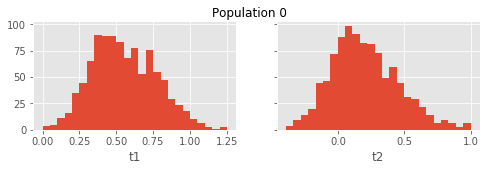

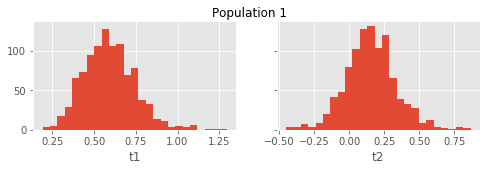

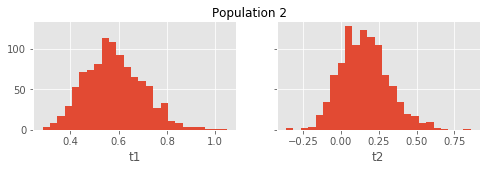

In [35]:
result_smc.plot_marginals_all_populations(bins=25, figsize=(8, 2), fontsize=12)

Obviously one still has direct access to the samples as well, which allows custom plotting:

(-1, 1)

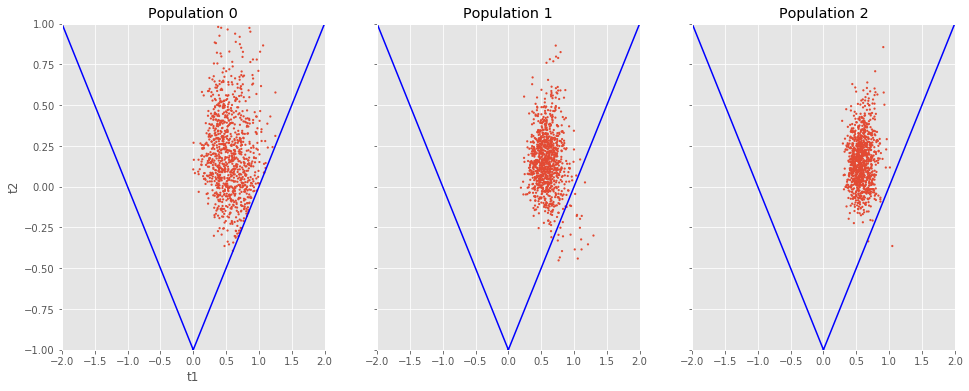

In [36]:
n_populations = len(schedule)
fig, ax = plt.subplots(ncols=n_populations, sharex=True, sharey=True, figsize=(16,6))
samples = [pop.samples_list for pop in result_smc.populations]
for ii in range(n_populations):
    s = samples[ii]
    ax[ii].scatter(s[0], s[1], s=5, edgecolor='none');
    ax[ii].set_title("Population {}".format(ii));
    ax[ii].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')
ax[0].set_xlabel(result_smc.names_list[0]);
ax[0].set_ylabel(result_smc.names_list[1]);
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-1, 1])

It can be seen that the populations iteratively concentrate more and more around the true parameter values.

Note that for the later populations some of the samples lie outside allowed region. This is due to the SMC algorithm sampling near previous samples, with *near* meaning a Gaussian distribution centered around previous samples with variance as twice the weighted empirical variance. However, the outliers carry zero weight, as was defined in the prior pdfs.

### Bayesian Optimization for Likelihood-Free Inference (BOLFI)

In practice inference problems often have a more complicated and computationally heavy simulator than the model `MA2` here, and one simply cannot run it for millions of times. The [BOLFI](http://jmlr.csail.mit.edu/papers/v17/15-017.html) framework is likely to prove useful in such situation: a statistical model (e.g. [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process), GP) is created for the discrepancy, and its minimum is inferred with [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization). This approach typically reduces the number of required simulator calls by several orders of magnitude.

When dealing with a Gaussian process, it is advisable to take a logarithm of the discrepancies in order to reduce the effect that high discrepancies have on the GP. In ELFI such transformed node can be created easily:

In [37]:
log_d = elfi.Operation(np.log, d)

As BOLFI is a more advanced inference method, its interface is also a bit more involved. But not much: Using the same graphical model as earlier, the inference could begin by defining a Gaussian process model, for which we use the [GPy](https://sheffieldml.github.io/GPy/) library. This could then be given via a keyword argument `target_model`. In this case, we are happy with the default that ELFI creates for us when we just give it each parameter some `bounds`.

Other notable arguments include the `initial_evidence`, which defines the number of initialization points sampled straight from the priors before starting to optimize the acquisition of points, and `update_interval` which defines how often the target model hyperparameters are optimized.

In [38]:
bolfi = elfi.BOLFI(log_d, batch_size=5, initial_evidence=20, update_interval=10, bounds=[(-2, 2), (-1, 1)])

Sometimes you may have some samples readily available. You could then initialize the GP model with a dictionary of previous results by giving `initial_evidence=result1.outputs`.

The BOLFI class can now try to `fit` the surrogate model (the GP) to the relationship between parameter values and the resulting discrepancies. We'll request 200 evidence points (including the `initial_evidence` defined above).

In [39]:
%time bolfi.fit(n_evidence=200)

INFO:elfi.methods.methods:BOLFI: Fitting the surrogate model...


CPU times: user 27.8 s, sys: 768 ms, total: 28.6 s
Wall time: 18.6 s


Running this does not return anything currently, but internally the GP is now fitted. 

Note that in spite of the very few simulator runs, fitting the model took longer than any of the previous methods. Indeed, BOLFI is intended for scenarios where the simulator takes a lot of time to run.

The fitted `target_model` uses the GPy libarary, which can be investigated further:

In [40]:
bolfi.target_model


Name : GP regression
Objective : 92.89482882471003
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  sum.rbf.variance         |  0.240718634943  |      +ve      |        
  sum.rbf.lengthscale      |  0.763579560393  |      +ve      |        
  sum.bias.variance        |  0.268059676697  |      +ve      |        
  Gaussian_noise.variance  |  0.116613123033  |      +ve      |        

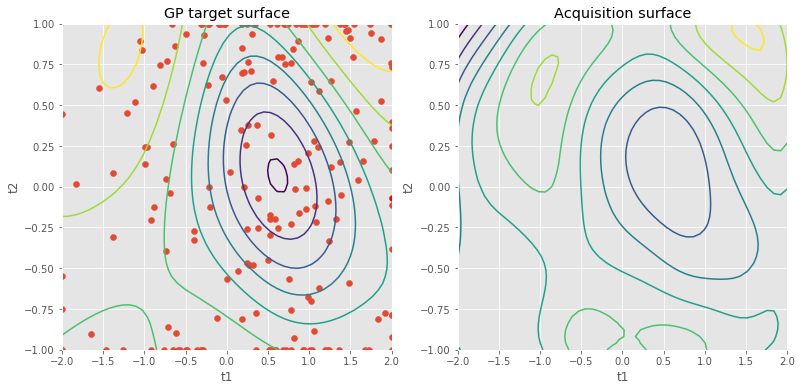

In [41]:
bolfi.plot_state();

It may be helpful to see the acquired parameter values and the resulting discrepancies:

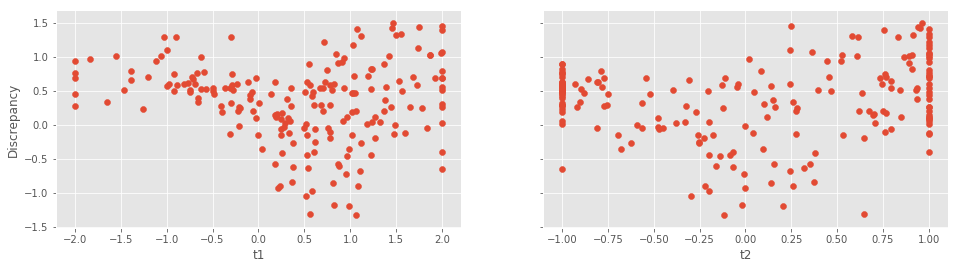

In [42]:
bolfi.plot_discrepancy();

Note the high number of points at parameter bounds. These could probably be decreased by lowering the covariance of the noise added to acquired points, defined by the optional `acq_noise_cov` argument for the BOLFI constructor.

We can now infer the BOLFI posterior (please see the [paper](http://jmlr.csail.mit.edu/papers/v17/15-017.html) for details). The method accepts a threshold parameter; if none is given, ELFI will use the minimum value of discrepancy estimate mean.

In [43]:
post = bolfi.infer_posterior()

INFO:elfi.methods.posteriors:Using minimum value of discrepancy estimate mean (-0.7723) as threshold


We can get estimates for *maximum a posteriori* and *maximum likelihood* easily:

In [44]:
post.MAP, post.ML

((array([ 0.61688696,  0.06964472]), array([[ 0.69314718]])),
 (array([ 0.6168865 ,  0.06964438]), array([[ 0.69314718]])))

We can visualize the posterior directly:

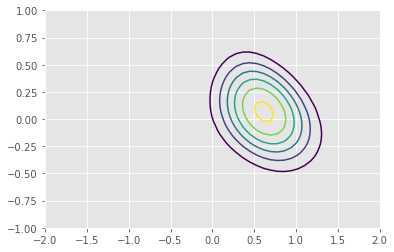

In [45]:
post.plot()

Finally, samples from the posterior can be acquired with an MCMC sampler (note that depending on the smoothness of the GP approximation, this may be slow):

In [46]:
# bolfi.model.computation_context.seed = 10
%time result_BOLFI = bolfi.sample(1000, target_prob=0.9)

INFO:elfi.methods.posteriors:Using minimum value of discrepancy estimate mean (-0.7723) as threshold
INFO:elfi.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.mcmc:NUTS: Iterations performed: 100/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 200/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 300/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 400/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 500/1000...
INFO:elfi.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.mcmc:NUTS: Iterations performed: 600/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 700/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 800/1000...
INFO:elfi.mcmc:NUTS: Iterations performed: 900/1000...
INFO:elfi.mcmc:NUTS: Acceptance ratio: 0.215, Diverged proposals after warmup (i.e. n_adapt=500 steps): 1
INFO:elfi.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.mcmc:NUTS: Iterations performed: 100/1000...
INFO:elfi.mcmc:NUTS: Iterations 

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
t1 1420.44243351 1.00154455113
t2 1927.74019939 1.00135368
CPU times: user 1min 55s, sys: 2.16 s, total: 1min 57s
Wall time: 1min 2s


The sampling algorithms may be fine-tuned with some parameters. If you get a warning about diverged proposals, something may be wrong and should be investigated. You can try rerunning the `sample` method with a higher target probability `target_prob` during adaptation, as its default 0.6 may be inadequate for a non-smooth GP, but this will slow down the sampling.

Now we finally have a `Result` object again, which has several convenience methods:

In [47]:
result_BOLFI

Method: BOLFI
Number of posterior samples: 2000
Number of simulations: 200
Threshold: -0.772
Posterior means: t1: 0.618, t2: 0.0644

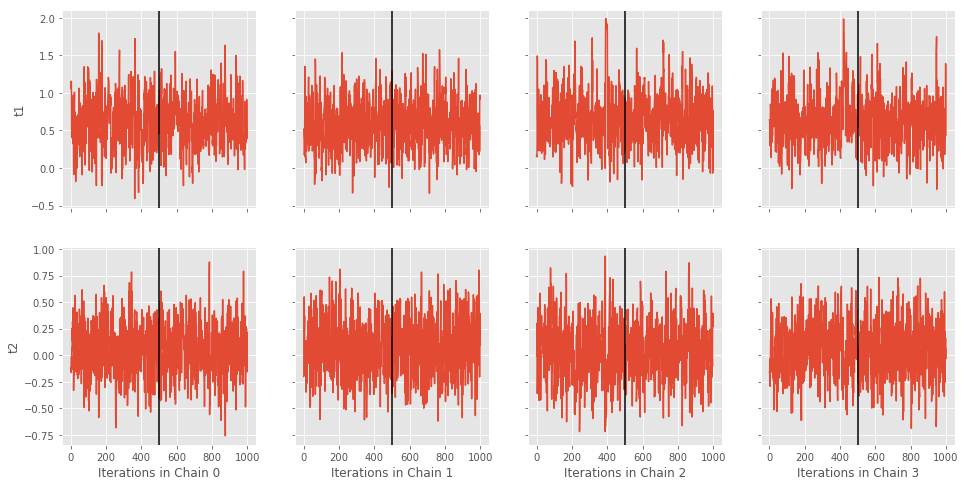

In [48]:
result_BOLFI.plot_traces();

The black vertical lines indicate the end of warmup, which by default is half of the number of iterations.

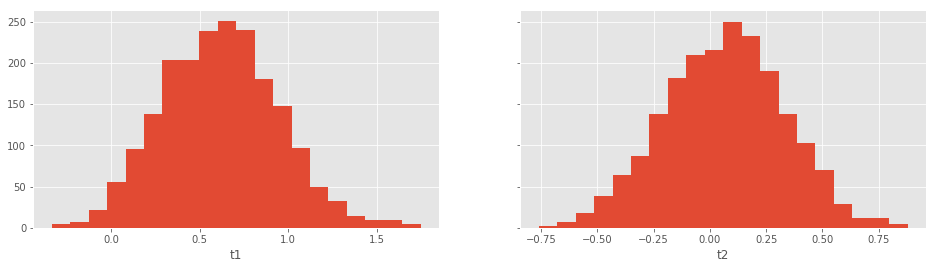

In [49]:
result_BOLFI.plot_marginals();

### That's it! See the other notebooks for more topics on e.g. using external simulators and parallelization.

Full documentation can be found at http://elfi.readthedocs.io/. Limited user-support may be asked from elfi-support.at.hiit.fi, but the [Gitter chat](https://gitter.im/elfi-dev/elfi) is preferable.

If you create something that you think would benefit other ELFI users, please consider opening a pull request in an appropriate [category](https://github.com/elfi-dev), like ELFI itself or the Zoo.